In [1]:
import os
import random

import torch as T
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset
from torchvision import transforms

import numpy as np
import skimage

from skimage.io import imread
from skimage import io, transform
from skimage.transform import resize

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import inconsistent

from glob import glob

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

random.seed(23)
np.random.seed(23)

from tools_dendrogram import fancy_dendrogram, estimate_nb_cluster, display_dendro

# Context

The purpose of this notebook is to group images of supermarket products without knowing the labels of the images.
So we're dealing with an unsupervised classification task.

We have a database of 100 unlabelled images.

![img 1](./images/tsaK3G_MJvkRN_HAeFbs_yHOQxxpgOv.jpg)  ![img 2](./images/tsaK3G_MJvkRN_iRcEbD_UHfQmlB4MQ.jpg)  ![img 3](./images/tsaK3G_YDVzvE_JzyQJw_TJ0NWQE5Kp.jpg)

Our approach is based on 3 main ideas :
1. Use a pretrained model (here, squeezenet1_0) wich will help us to extract medium-level features.
2. Apply a reduction in dimensionality, because the model has been pretrained on IMAGENET and returns a highly redundant features vector.
3. Estimate a number of cluster automatically using ELBOW's method.


## Step 1: Extract features from all images 

In [2]:
PATH = "./images/*.jpg"
pretrained_network = torchvision.models.squeezenet1_0(pretrained=True).eval()

In [3]:
class TrasnferLearning(nn.Module):
    """
    This class is a feature extractor 
    """
    def __init__(self, pretained_model):
        super(TrasnferLearning, self).__init__()
        self.features = nn.Sequential(*list(pretained_model.features.children()))[:6]

    def forward(self, x):
        x = self.features(x)
        out = x.view(x.size(0), -1)
        return out

In [4]:
class DS(Dataset):
    """
    Dataset class
    """
    def __init__(self, path, train=True, transforms=None):
        self.imgs =  glob(path)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, item): 
        x = imread(self.imgs[item])
        #<!> all images doesn't the same size
        x = skimage.transform.resize(x, (64, 64)) 
        x = T.tensor(x).float().permute(2, 0, 1) / x.max()
        y = T.tensor([0]).long()
        return x, y

In [5]:
#data contains alls images as numpy.ndarray
data = [io.imread(img) for img in glob(PATH)]

In [6]:
train_loader = T.utils.data.DataLoader(
    DS(path=PATH),
    shuffle=False,
    batch_size=len(data)
)

In [7]:
model = TrasnferLearning(pretrained_network)

In [8]:
#extract features for alls images
img_features = []
for x, y in train_loader:
    img_features.extend(model(x).detach().numpy())

## Step 2: Dense features vectors

In [9]:
#reduce dimensionality
pca = PCA(.99)
img_embd_pca = pca.fit_transform(img_features)

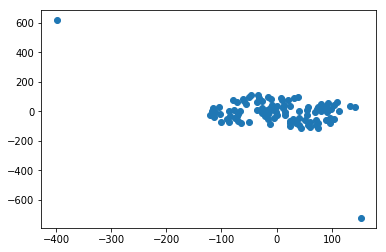

In [10]:
#first visualisation
tsne = TSNE()
img_2d = tsne.fit_transform(img_embd_pca)

plt.scatter(*img_2d.T)
plt.show()

## Step 3: automatic estimation of nb clusters

In [11]:
Z = linkage(img_embd_pca, 'ward')

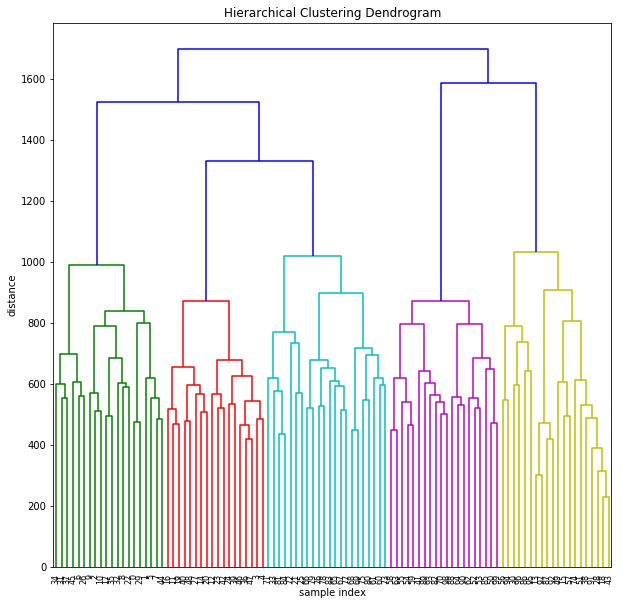

In [12]:
#drawing a dendrogram 
display_dendro(Z)

The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset. 

Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples above), and for each value of k calculate the sum of squared errors (SSE).

The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster)

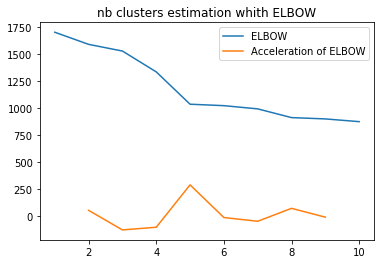

Nb clusters 5


In [13]:
k = estimate_nb_cluster(Z)
print('Nb clusters', k)

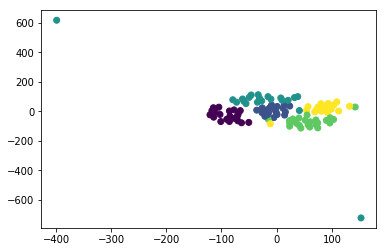

In [14]:
kmeans = KMeans(k)
y = kmeans.fit_predict(img_embd_pca)


plt.scatter(*img_2d.T, c=y)
plt.show()

## Visualisation of cluster assignement

In [15]:
def mkdir(path):
    try: os.mkdir(path)
    except: pass

#save images by cluster

for c in set(y):
    file_c = "./clusters_{}".format(c)
    mkdir(file_c)
    indices = np.where(y == c)[0]
    #selected_img = data_pca[indices]
    selected_img = np.array(data)[indices]
    #delete old asigned images
    for p in glob(file_c + '/*.png'):
        os.remove(p)
    #save the new assigments
    for i, img in enumerate(selected_img):
            io.imsave("{}/img_{}.png".format(file_c, i), img)


In [16]:
def display_cluster1(id_cluster):
    imgs = glob("./clusters_{}/*.png".format(id_cluster))
    for im in imgs:
        plt.figure(figsize=(1, 1))
        plt.imshow(resize(io.imread(im), (32, 32)))
        plt.show()
        
def display_cluster(id_cluster):
    imgs = glob("./clusters_{}/*.png".format(id_cluster))
    row = 3
    col = len(imgs) // row

    col = col + 1 if row * col != len(imgs) else col
    fig, ax = plt.subplots(row, col, sharex='col', sharey='row', figsize=(8,3)) #col, row

    for i in range(row):
        for j in range(col):
            if i * col + j < len(imgs) :
                #print(k,i, j, i * col + j )
                ax[i, j].imshow(resize(io.imread(imgs[i * col + j]), (32, 32)))
                
            else:
                ax[i, j].imshow(np.ones((32, 32)))#+ 225.)

    plt.show()


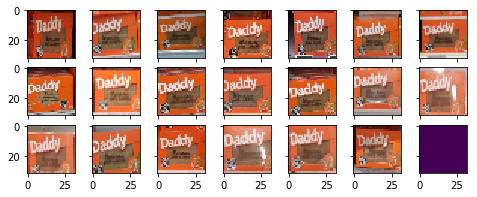

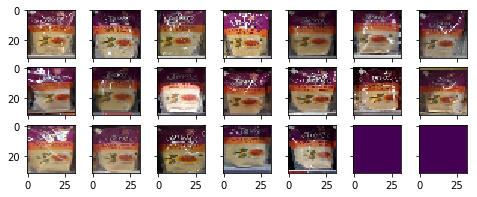

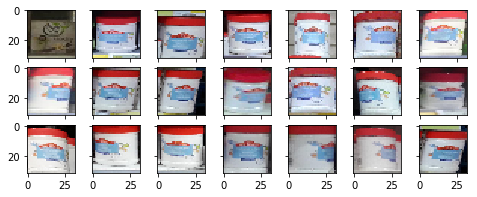

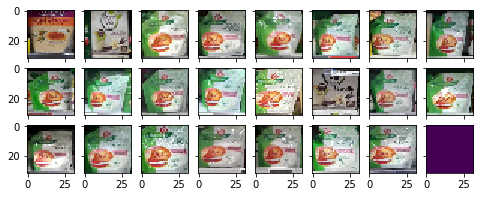

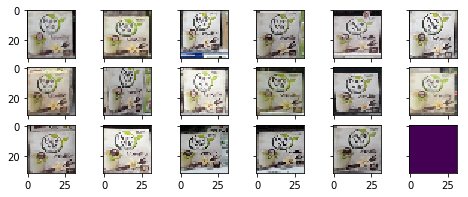

In [17]:
for i in range(k):
    display_cluster(i)

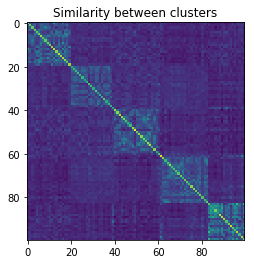

In [18]:
#<!> trier les images selons les labels
dimg_embd_sorted = np.array(list(zip(*sorted(zip(y, img_embd_pca), key=lambda t: t[0])))[1])
plt.title("Similarity between clusters")
plt.imshow(dimg_embd_sorted.dot(dimg_embd_sorted.T))